# 3D PET Iterative reconstruction demo

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

### Introduction

This notebook shows how to perform iterative reconstruction using the DAPHNE framework. As illustrated in Chapter 2 of the book (https://www.taylorfrancis.com/books/9780429270239), DAPHNE (Didactic tomogrAPHic recoNstruction framEwork) includes several high-level tools and functions allowing the user to perform simple reconstruction within the main reconstruction algorithms.

In this notebook, the specific case iterative PET reconstruction is considered. The main steps covered here can be summarized as follows: 

1. Library import
2. Setting up the geometry
3. Loading the voxelized 3D Shepp-Logan head phantom (and displaying it)
4. Forward projecting the phantom using the Siddon method
5. Setup and perform the iterative reconstruction algorithm. The iterative algorithms currently implemented in DAPHNE are ART, SIRT, MLEM OSEM. For a description of the algorithms, the reader is referred to chap 4 of the book. 
6. Displaying the reconstructed image

The main preparatory steps and imports to begin are reported in the cell below.

In [1]:
import sys
import numpy as np
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage
from Misc.Preview import Visualize3dImage
from Geometry.ExperimentalSetupPET import ExperimentalSetupPET
import matplotlib.pyplot as plt
from Algorithms.ProjectionDataGenerator import ProjectionDataGenerator 
from Algorithms.ART import ART
from Algorithms.SIRT import SIRT
from Algorithms.MLEM import MLEM
from Algorithms.OSEM import OSEM
from Misc.DataTypes import voxel_dtype
# set the default size of all the plots
plt.rcParams['figure.figsize'] = [10, 10] 
# if images are too big or too small try to play whit these numbers
%matplotlib notebook
# the cell below will disable the autoscrolling feature 

The cell below will just disable the autoscrolling feature:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

###  Create a PET experimental setup

Now, we are going to create an experimental setup by defining a PET detector and a Target Region (TR). This information will be collected in the ExperimentalSetupPET class.  We will use a PET cylindrical detector made of 400 pixels per slice and 4 slices. 
The main parameters needed to define the experimental setup are:

* radius_mm (scalar,float): value defining the radius of the cylindrical PET scanners in mm.
* pixels_per_slice_nb (scalar,int):  number of pixel for each detector slice, i.e. number of pixels per detector row. 
* detector_slice_nb (scalar,int): number of detector slices.
* slice_pitch_mm (scalar,float): distance in mm between two consecutive slice centers.
* image_matrix_size_mm (3 item long np.array,float): array containing the size of the TR in mm along x-y-z.
* voxel_size_mm (3 item long np.array,float): array containing the size in mm of each voxel. **Note**:  the number of voxels in each direction is a derived parameter calculated on top of image_matrix_size_mm and voxel_size_mm (see ExperimentalSetup.py ```ExperimentalSetup::CalculateTRSizeInVoxels```).
* h_fan_size (scalar,int): this parameter is used to define which projections are acquired by the PET detector. The higher this number, the higher the number of projections will be! The idea behind this parametrization is that each pixel is paired with the  $(2*h\_fan\_size+1)\cdot detector\_slice\_nb$ in front of it. The figure below shows the idea behind this parameter for a PET detector with $pixels\_per\_slice\_nb=20$, $h\_fan\_size=3$ and $detector\_slice\_nb=1$) 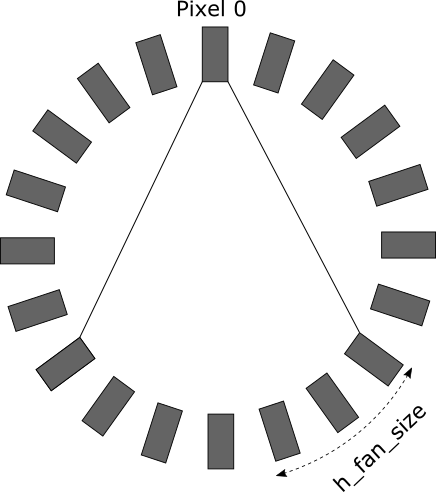](attachment:image.png)


In [3]:
# create an empty PET experimental setup
my_experimental_setup = ExperimentalSetupPET()
# radius of the cylindrical PET
my_experimental_setup.radius_mm=100
# size of the pixels (visualization purpose only)
my_experimental_setup.pixel_size=np.array([1,1,10])
# number of pixels in the cylindrical geom
my_experimental_setup.pixels_per_slice_nb=400 
# number of detector's slice
my_experimental_setup.detector_slice_nb=4
# pitch of the detector slices 
my_experimental_setup.slice_pitch_mm=2.5
# fov size in mm 
my_experimental_setup.image_matrix_size_mm = np.array([100,100,10])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([1,1,2.5])
# h size of for the coincidences
my_experimental_setup.h_fan_size = 80
# (optional) give a name to the experimental setup 
my_experimental_setup.detector_name = "my first PET detector"

Once the geometry is created and set up, we will call the ```Update()``` method to apply all the settings and calculated derived variables. The resulting setup parameters can be displayed using the ```GetInfo()``` method. 

**Note**: since DAPHNE is not optimized for performance, check that the parameter ```number of projections```  $< 5\cdot10^5$ otherwise your experiment will take a lot of time to run!.  

In [4]:
##### this triggers the computation of the internal parameters needed by the reconstruction algorithms
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())

detector_type: DetectorType.PET
radius_mm: 100
pixel_size: [ 1  1 10]
pixels_per_slice_nb: 400
detector_slice_nb: 4
slice_pitch_mm: 2.5
image_matrix_size_mm: [100 100  10]
voxel_size_mm: [1.  1.  2.5]
h_fan_size: 80
detector_name: my first PET detector
number of projections: 515200


## Display the experimental setup

The ```Draw()``` method of the ```ExperimentalSetupPET``` class will allow us to display the geometry (source and detector position(s), as well as the reconstruction matrix). When using ```use_jupyter=1```, only a static figure will be displayed in the notebook itself. Otherwise, the user can obtain an interactive display of the same geometry by putting ```use_jupyter=0``` as the first argument. The second argument is the position of the camera in the static (```use_jupyter=1```) mode. Note that the camera is always pointing the center of the TR.  

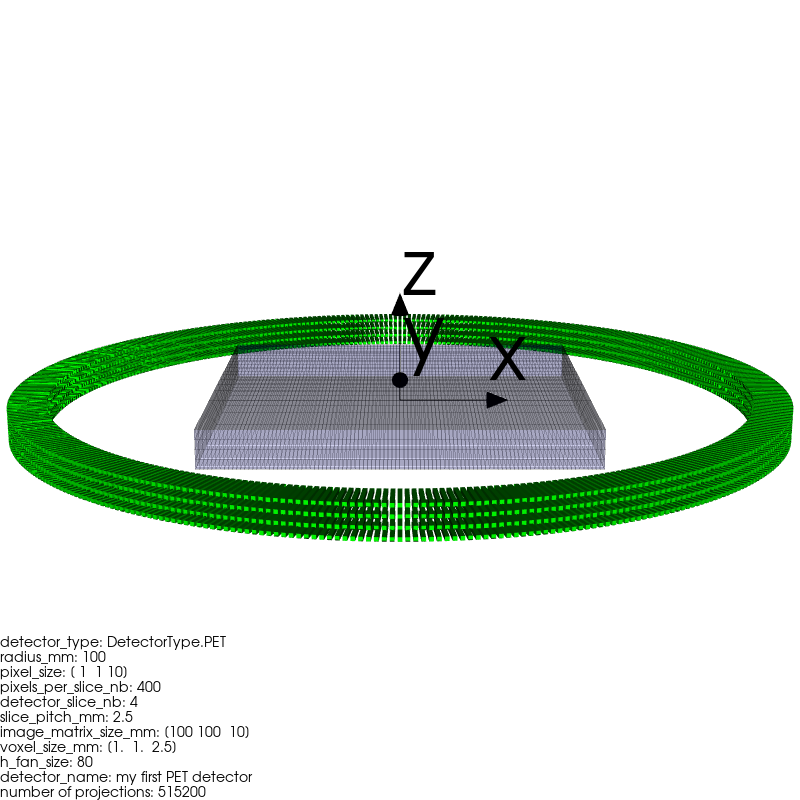

In [5]:
# note that, on some system, using use_jupyter=0 option can result in unstable behavior
my_experimental_setup.Draw(use_jupyter=1,camera_pos_mm=(0,-400,100))

### Load the image used to generate the LOR data

We are now ready to lead the example dataset provided, a voxelised 3D version of the Shepp-Logan head phantom. Upon loading the dataset, made up by a (rather coarse) grid of 100x100x100  voxels.

In [6]:
input_img = np.fromfile("../Data/SheppLogan3D_100x100x100_16bit_us.raw",dtype=np.uint16).reshape ((100,100,100))
input_img=input_img.astype(voxel_dtype)
# rearrange the image so that it is displayed properly
input_img = np.transpose(input_img, (1,2,0))
# take 4 slices around the center of the TR, one every 10 slices of the orginal phantom
# (selected slices id's will be 30, 40, 50 and 60)
input_img = input_img [:,:,30:70:10]

By calling the Visualize3dImage() method from Misc.Preview, we can easily display the loaded volume by interactively selecting the slice (use the slider at the bottom of the figure).

<IPython.core.display.Javascript object>


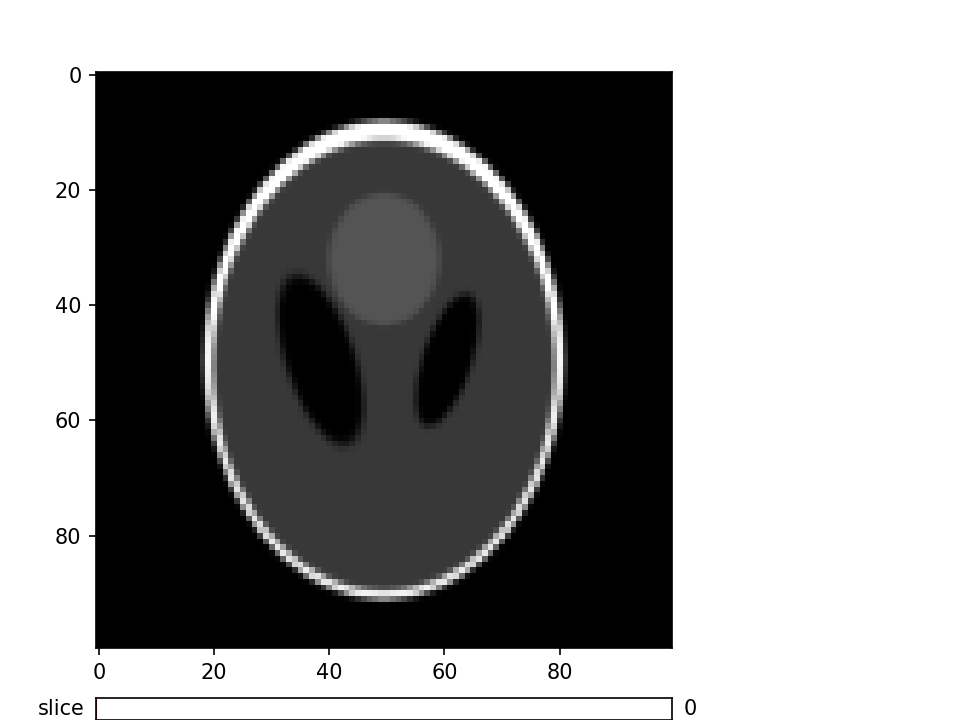

In [7]:
Visualize3dImage(input_img)

### Generate LOR data
Now we are ready to generate a set of projection data that will allow you to perform few experiments. As for the generation of the sinogram, we use the Siddon algorithm to give an estimation of the projections value that would be generated by and our phantom image. Two final remarks: 
* this is just a way to perform simple experiments, without the need of using more complicated tools like Monte Carlo simulations, which are well beyond the book scope.
* in a real life, this step is not needed, since data to be reconstructed are coming directly from the PET scanner.

In [8]:
g=ProjectionDataGenerator(my_experimental_setup)
# add noise to proj: 0 no noise added to projection 1 add poisson noise 2 add gaussian noise
noise=0
projections=g.GenerateObjectProjectionData(input_img, noise,0)

### Setup the reconstruction algorithm 
Here we define the parameters needed by the reconstruction algorithms. You can choose between ART,SIRT,MLEM and OSEM.
The parameters you need to define are: 
*  Algorithm (scalar,string): must be one of the following strings "MLEM", "ART", "SIRT", "OSEM"
*  Number of iterations (scalar,int): the number of times the itearative formula is applied.
*  Initial value (scalar,float): constant value to fill the initial guess image to start iterative procedure. 
*  Number of subsets (OSEM only) (scalar,int): the number of subsets to divide data.   
Check chap 4 of the book to understand how each algorithm works.

In [9]:
# algorithm must be one of "MLEM", "ART", "SIRT", "OSEM"
algorithm="ART"
# number of iterations 
niter=2
# number of subsets (OSEM only)
nsubsets=10
# when use using MLEM or OSEM remember to set this value to !=0 
initial_value=1

### Save the iterations to disk
If you want to save all the iterations to disk remember define the ```basename``` variable and to uncomment ```it.SetOutputBaseName(basename)``` in the "Run reconstruction" cell.

In [10]:
# uncomment the line below to save the images to disk
#basename="test_"+algorithm

### Run reconstruction

This step might take a few minutes to complete.

In [11]:
it = eval( algorithm+ "()")
it.SetExperimentalSetup(my_experimental_setup)
it.SetNumberOfIterations(niter)
it.SetNumberOfSubsets(nsubsets)
it.SetProjectionData(projections)
# start with a initial_guess filled image
initial_guess=np.full(it.GetNumberOfVoxels(),initial_value, dtype=voxel_dtype) 
it.SetImageGuess(initial_guess)
# uncomment this line to save images to disk
#it.SetOutputBaseName(basename)
output_img = it.Reconstruct()

Algorithm name ART
iteration 1 => time: 90.2 s
iteration 2 => time: 90.5 s
Done


### Display the reconstruction results

We can now inspect the resulting reconstructed image ```output_img```

<IPython.core.display.Javascript object>


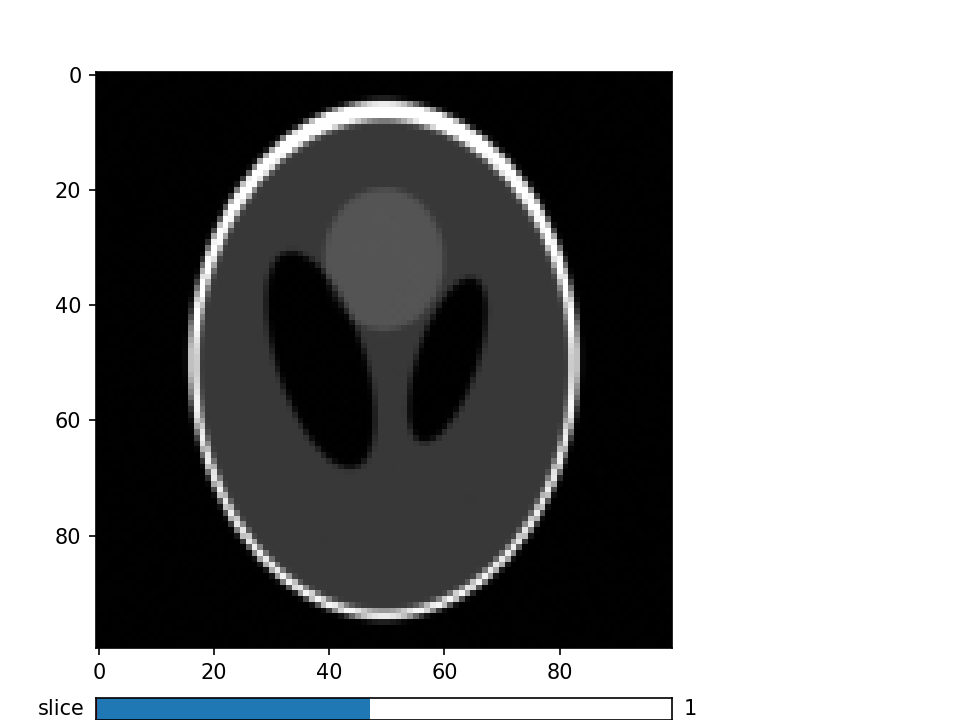

In [12]:
Visualize3dImage(output_img)